In [11]:
%load_ext autoreload
%autoreload 2

import torch
from model import PointNet
from dataset import lm2flat_index
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import numpy as np

torch.backends.cudnn.benchmark = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from typing import List, Tuple
from dataset import OctantDataset
from pytorch3d.structures import Pointclouds
import torch.utils.data as data

ds = OctantDataset("../datasets/simple_32_sh",preload=True) # neuschwanstein_2000_32max_sh

def collate_batched_point_clouds(batch: List[Tuple[Pointclouds, torch.Tensor]]):
    coefs = torch.stack([x[1] for x in batch])
    pcs = Pointclouds(
        points=[x[0].points_packed() for x in batch],
        features=[x[0].features_packed() for x in batch],
    )
    return (pcs, coefs)

num_train = int(0.8*len(ds))

ds_train, ds_val = data.random_split(ds,[num_train,len(ds)-num_train])

batch_size = 4096

import math
r = torch.randperm(len(ds_train))
train_batches = torch.arange(len(ds_train))[r].chunk(math.ceil((len(ds_train)/batch_size)))

r = torch.randperm(len(ds_val))
val_batches = torch.arange(len(ds_val))[r].chunk(math.ceil((len(ds_val)/batch_size)))


len(ds_train),len(ds_val)

(8000, 2000)

In [3]:
l = 3
model = PointNet((l + 1) ** 2,batch_norm=True).cuda()

sum(p.numel() for p in model.parameters() if p.requires_grad)

811312

In [4]:
coefs = torch.stack([c[ : lm2flat_index(l, -l) + 1] for _,c in ds_train])
norm_a = coefs.mean(0)
norm_b = coefs.std(0)
coefs.shape

torch.Size([8000, 16, 3])

tensor([0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
        0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625])


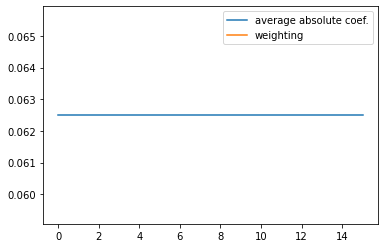

In [5]:
import numpy as np

coefs_n = (coefs-coefs.mean(0))/coefs.std(0) 
avg_coefs = coefs.abs().permute(1,0,2).flatten(1).mean(1)

def weightedL2Loss(weights:torch.Tensor):
    def loss(prediction:torch.Tensor,target:torch.Tensor)->torch.Tensor:
        diff = prediction-target
        l2 = diff.square().sum(-1)
        return (l2*weights.to(prediction.device)).mean()
    return loss   

weighting = 1/avg_coefs
weighting /= weighting.sum() #normalize

x =torch.arange(0,len(weighting))

A = torch.ones((len(weighting),2))
A[:,0]= x.log()


a,b = torch.linalg.lstsq(A,weighting.cpu()).solution
if a == b == 0:
    new_weights = torch.ones(1)
else:
    new_weights = (a*x.log()+b).clip(0,1)
    new_weights = new_weights/new_weights.sum()

    new_weights += 0.05
    new_weights = new_weights/new_weights.sum()

weighting = torch.ones_like(weighting)/len(weighting)


plt.plot(weighting.cpu(),label="average absolute coef.")
plt.plot(new_weights,label="weighting")
plt.legend()
mse_loss = weightedL2Loss(weighting)
print(weighting)


In [6]:
from torch.optim.lr_scheduler import OneCycleLR
from lrcurve import PlotLearningCurve

epochs = 10 * 100

optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4)

scheduler = OneCycleLR(optimizer,max_lr=1e-3,steps_per_epoch=len(train_batches),epochs=epochs)

# mse_loss = torch.nn.MSELoss()

def unpack_data(pcs:Pointclouds):
    vertices = pcs.points_packed().cuda()
    color = (pcs.features_packed()[:, :3]).cuda().float() / 255.0
    batch = pcs.packed_to_cloud_idx().cuda()
    return vertices,color,batch


plot = PlotLearningCurve(
    mappings = {
        'loss': { 'line': 'train', 'facet': 'loss' },
        'val_loss': { 'line': 'validation', 'facet': 'loss' },
    },
    facet_config = {
        'loss': { 'name': 'L2', 'limit': [None, None], 'scale': 'log10' },
    },
    xaxis_config = { 'name': 'Step', 'limit': [0, None] }
)
step = 0
with tqdm(total=epochs) as pbar:
    pbar.total = epochs
    for epoch in range(epochs):
        pbar.set_description(f"epoch")

        for i,batch_indices in enumerate(train_batches):
            pcs,coefs = collate_batched_point_clouds([ds_train[i] for i in batch_indices])
            model.train().requires_grad_(True)
            optimizer.zero_grad()

            vertices,color,batch = unpack_data(pcs)
            target_coefs = coefs[:,:lm2flat_index(l,-l)+1].cuda()
            # target_coefs = (target_coefs - norm_a.cuda())/norm_b.cuda()

            pred_coefs = model(vertices, color, batch)
            pred_coefs = pred_coefs * norm_b.cuda() + norm_a.cuda()
            train_loss:torch.Tensor = mse_loss(pred_coefs, target_coefs)
            train_loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=1.)
            optimizer.step()
            scheduler.step()

            # do validation batch every 4th train batch
            if i%4 == 0:
                model.eval()
                rand_sample = torch.randint(0,len(val_batches),(1,)).item()
                pcs,coefs = collate_batched_point_clouds([ds_val[i] for i in val_batches[rand_sample]])
                vertices,color,batch = unpack_data(pcs)
                target_coefs = coefs[:, : lm2flat_index(l, -l) + 1].cuda()
                pred_coefs = model(vertices, color, batch)
                pred_coefs = pred_coefs * norm_b.cuda() + norm_a.cuda()
                val_loss:torch.Tensor = mse_loss(pred_coefs, target_coefs)
                plot.append(step,{
                    'val_loss': val_loss.item()
                })
            plot.append(step, {
                'loss': train_loss.item(),
            })
            plot.draw()
            step+=1
        pbar.update()

<IPython.core.display.Javascript object>

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
from sh import calc_sh

res = 100
x = torch.arange(0,1,1/res)
grid_x,grid_y = torch.meshgrid(x*torch.pi,x*2*torch.pi,indexing="ij")
coords = torch.stack((grid_x.flatten(),grid_y.flatten())).T

y = calc_sh(l,coords)

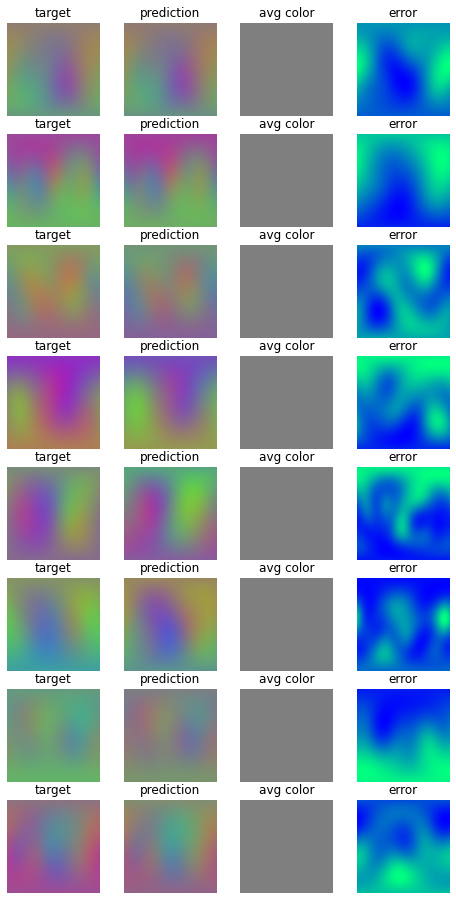

In [19]:
model.eval()
model.requires_grad_(False)

rand_sample = torch.randint(0,len(val_batches),(1,)).item()
pc,a_lm = collate_batched_point_clouds([ds_val[i] for i in val_batches[rand_sample]])

pred_a = model(*unpack_data(pc)).squeeze(0)
pred_a = pred_a * norm_b.cuda() + norm_a.cuda()
a_lm = a_lm[:,:lm2flat_index(l, -l) + 1]

fig,axes = plt.subplots(8,4,figsize=(8,16))

for i in range(8):
    ax1,ax2,ax3,ax4 = axes[i]


    ax3.set_title("avg color")
    ax3.set_axis_off()
    avg =pc.features_list()[i].float().mean(0).reshape(1,1,4) / 255.
    ax3.imshow(avg)

    ax1.set_title("target")
    ax1.set_axis_off()
    target = (y@a_lm[i].cpu()).reshape(res,res,-1)
    ax1.imshow(target+avg[:,:,:3])


    ax2.set_title("prediction")
    ax2.set_axis_off()
    prediction =(y@pred_a[i].cpu()).reshape(res,res,-1)
    ax2.imshow(prediction+avg[:,:,:3])


    ax4.set_title("error")
    ax4.set_axis_off()
    error = (prediction-target).square().mean(-1)
    ax4.imshow(error,cmap="winter")

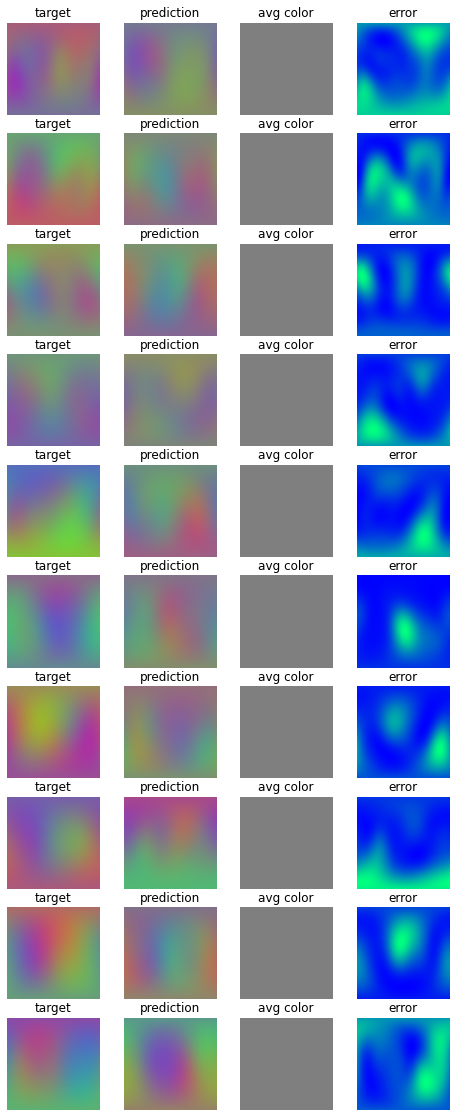

In [21]:
model.eval()
model.requires_grad_(False)

losses = []
preds = []
for i,batch_indices in enumerate(val_batches):
    pcs,coefs = collate_batched_point_clouds([ds_val[i] for i in batch_indices])
    pred_a: torch.Tensor = model(*unpack_data(pcs)).squeeze(0).cpu()
    pred_a = pred_a * norm_b + norm_a
    a_lm = coefs[:,:lm2flat_index(l, -l) + 1]
    diff = pred_a-a_lm
    l2 = diff.square().sum(-1).mean(-1)
    losses.append(l2)
    preds.append(pred_a)
values, indices = torch.cat(losses).topk(10)
pred_a = torch.cat(preds)

fig,axes = plt.subplots(10,4,figsize=(8,20))

for i,sample in enumerate(indices.tolist()):
    ax1,ax2,ax3,ax4 = axes[i]
    pcs,coefs = ds_val[sample]
    coefs = coefs[:lm2flat_index(l, -l) + 1]
    pred_coefs = pred_a[sample]

    ax3.set_title("avg color")
    ax3.set_axis_off()
    avg = pcs.features_list()[0].float().mean(0).reshape(1,1,4) / 255.
    avg = avg[:,:,:3].cpu()
    ax3.imshow(avg)

    ax1.set_title("target")
    ax1.set_axis_off()
    target = (y@coefs.cpu()).reshape(res,res,-1)
    ax1.imshow(target+avg)

    ax2.set_title("prediction")
    ax2.set_axis_off()
    prediction =(y@pred_coefs.cpu()).reshape(res,res,-1)
    ax2.imshow(prediction+avg)

    ax4.set_title("error")
    ax4.set_axis_off()
    error = (prediction-target).square().mean(-1)
    ax4.imshow(error.cpu(),cmap="winter")

In [ ]:
plt.ylabel("value")
plt.xlabel("coef.")
# plt.plot((a_lm-pred_a.cpu()).norm(2,-1).mean(0),label="error")
plt.plot((pred_a.cpu()).norm(2,-1).mean(0),label="prediction")
plt.plot((a_lm.cpu()).norm(2,-1).mean(0),label="target")
plt.legend()
plt.yscale("log")

In [ ]:
plt.ylabel("error")
plt.xlabel("coef.")
plt.plot((coefs-pred_a).norm(2,-1).mean(0).cpu(),label="error")
plt.legend()
# plt.yscale("log")